### Imports

In [2]:
from typing import Iterable, List, Dict, Callable
import os
import gc

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Constants

In [4]:
PATH_TO_DATA = "hydraulic-systems/"
NUMBER_OF_PROFILES = 2205
PROFILE_MAX_SAMPLE_RATE = 6000
TARGET_NAMES = ["cooler", "valve", "leakage", "accumulator", "stable"]

PLOT_STYLE = "darkgrid"

In [5]:
TARGET_VALUES_MAP = {
    "cooler": {
        3: "close to total failure",
        20: "reduced effifiency",
        100: "full efficiency",
    },
    "valve": {
        100:"optimal switching behavior",
        90: "small lag",
        80: "severe lag",
        73: "close to total failure",
    }, 
    "leakage": {
        0: "no",
	    1: "weak",
	    2: "severe",
    },
    "accumulator": {
        130: "optimal pressure",
    	115: "slightly reduced pressure",
	    100: "severely reduced pressure",
	    90:  "close to total failure",
     },
     "stable":{
        0: "yes",
	    1: "not",
     }
}

### Load data

In [6]:
sersor_files_config = [
    {"name": "CE", "upsample_coeff": 100},
    {"name": "CP", "upsample_coeff": 100},
    {"name": "EPS1", "upsample_coeff": 1},
    {"name": "FS1", "upsample_coeff": 10},
    {"name": "FS2", "upsample_coeff": 10},
    {"name": "PS1", "upsample_coeff": 1},
    {"name": "PS2", "upsample_coeff": 1},
    {"name": "PS3", "upsample_coeff": 1},
    {"name": "PS4", "upsample_coeff": 1},
    {"name": "PS5", "upsample_coeff": 1},
    {"name": "PS6", "upsample_coeff": 1},
    {"name": "SE", "upsample_coeff": 100},
    {"name": "TS1", "upsample_coeff": 100},
    {"name": "TS2", "upsample_coeff": 100},
    {"name": "TS3", "upsample_coeff": 100},
    {"name": "TS4", "upsample_coeff": 100},
    {"name": "VS1", "upsample_coeff": 100},
]

In [7]:
def get_files_with_resample(config: List[Dict]) -> Iterable[np.ndarray]:
    for file in config:
        data = np.genfromtxt(PATH_TO_DATA + file["name"] + ".txt", dtype=float, delimiter='\t')
        yield np.repeat(data, file["upsample_coeff"], axis=1).flatten()

In [8]:
def load_feature_dataframe(config: List[Dict]) -> pd.DataFrame:
    columns = [file["name"] for file in config]
    data = np.stack(get_files_with_resample(config), axis=-1)
    data_df = pd.DataFrame(data, columns=columns)

    prodile_ids = np.repeat(range(1, NUMBER_OF_PROFILES+1), PROFILE_MAX_SAMPLE_RATE)
    prodile_ids_df = pd.DataFrame(prodile_ids, columns=["profile_id"])

    return pd.concat([prodile_ids_df, data_df], axis=1, sort=False)

In [9]:
def load_targets(filename: str) -> pd.DataFrame:
    conditions_data = np.genfromtxt(PATH_TO_DATA + filename, dtype=int, delimiter='\t')
    conditions_df = pd.DataFrame(conditions_data, columns=TARGET_NAMES)

    prodile_ids = range(1, NUMBER_OF_PROFILES+1)
    prodile_ids_df = pd.DataFrame(prodile_ids, columns=["profile_id"])

    return pd.concat([prodile_ids_df, conditions_df], axis=1, sort=False)

In [11]:
feature_df = load_feature_dataframe(sersor_files_config)
target_df = load_targets("profile.txt") #Note that targets is define for profile, not to points

_ = gc.collect()

### Basic EDA

In [12]:
feature_df.head()

,profile_id,CE,CP,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,PS6,SE,TS1,TS2,TS3,TS4,VS1
0,1,47.202,2.184,2411.6,8.99,10.179,151.47,125.50,2.305,0.0,9.936,9.818,68.039,35.57,40.961,38.32,30.363,0.604
1,1,47.202,2.184,2411.6,8.99,10.179,151.45,125.39,2.305,0.0,9.947,9.823,68.039,35.57,40.961,38.32,30.363,0.604
2,1,47.202,2.184,2411.6,8.99,10.179,151.52,125.40,2.336,0.0,9.964,9.844,68.039,35.57,40.961,38.32,30.363,0.604
3,1,47.202,2.184,2411.6,8.99,10.179,151.27,125.03,2.578,0.0,9.989,9.861,68.039,35.57,40.961,38.32,30.363,0.604
4,1,47.202,2.184,2411.6,8.99,10.179,150.80,124.05,2.977,0.0,9.996,9.877,68.039,35.57,40.961,38.32,30.363,0.604


In [ ]:
feature_df.tail()

In [14]:
target_df.head()

,profile_id,cooler,valve,leakage,accumulator,stable
0,1,3,100,0,130,1
1,2,3,100,0,130,1
2,3,3,100,0,130,1
3,4,3,100,0,130,1
4,5,3,100,0,130,1


In [15]:
target_df.tail()

,profile_id,cooler,valve,leakage,accumulator,stable
2200,2201,100,100,0,90,0
2201,2202,100,100,0,90,0
2202,2203,100,100,0,90,0
2203,2204,100,100,0,90,0
2204,2205,100,100,0,90,0


In [16]:
def generate_encoder(target_labels: Dict[str, Dict[int, str]], feature_name: str) -> Callable:
    encodes = target_labels[feature_name]

    def encode(value: int) -> str:
        return encodes[value]
    
    return encode

In [17]:
def plot_profile(df: pd.DataFrame, target_df: pd.DataFrame, profile_id: int, features: List[str] = []):
    filtered_df = df[features][df.profile_id == profile_id].reset_index()

    profile_target_values = target_df[target_df.profile_id == profile_id][TARGET_NAMES].to_dict("records")[0]
    profile_target_labels = [f"{k}: {generate_encoder(TARGET_VALUES_MAP, k)(v)}" for k, v in profile_target_values.items()]

    with sns.axes_style(PLOT_STYLE):
        figure, axes = plt.subplots(len(features), 1, figsize=(15, len(features)*2), sharex=True)
        figure.suptitle(f'{", ".join(profile_target_labels)}', fontsize=14)
        plt.xlabel("sample")

        for ax, feature_name in zip(axes, features):
            ax.plot(filtered_df[feature_name])
            ax.set_ylabel(feature_name)

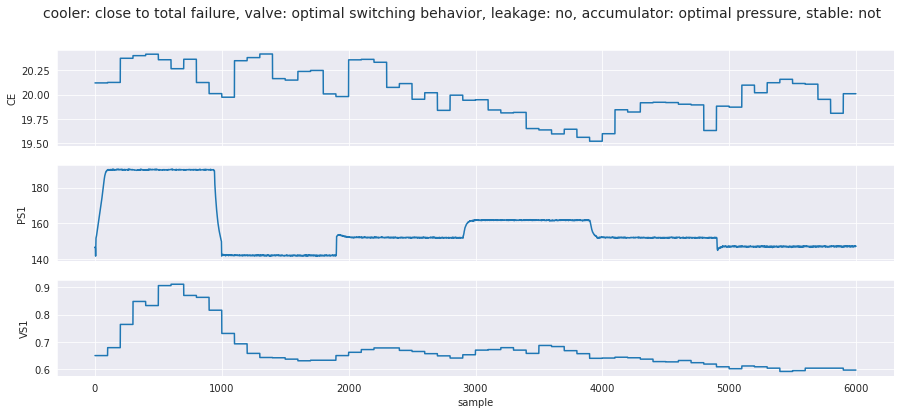

In [24]:
plot_profile(feature_df, profile_id=200, target_df=target_df, features=["CE", "PS1", "VS1"])

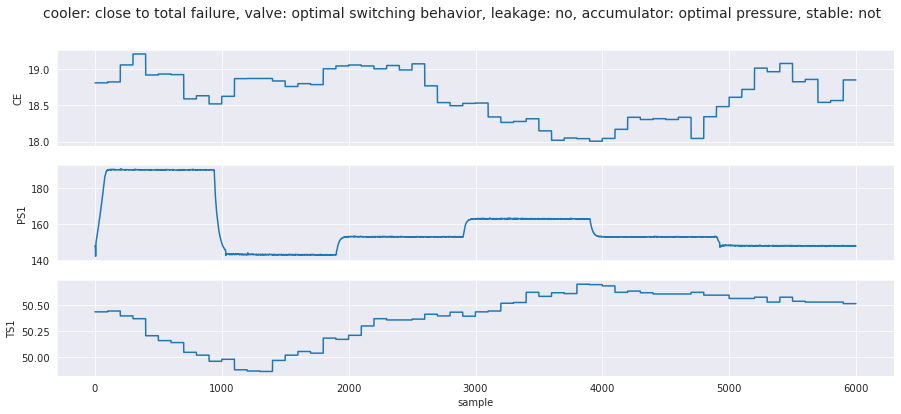

In [25]:
plot_profile(feature_df, profile_id=35, target_df=target_df, features=["CE", "PS1", "TS1"])

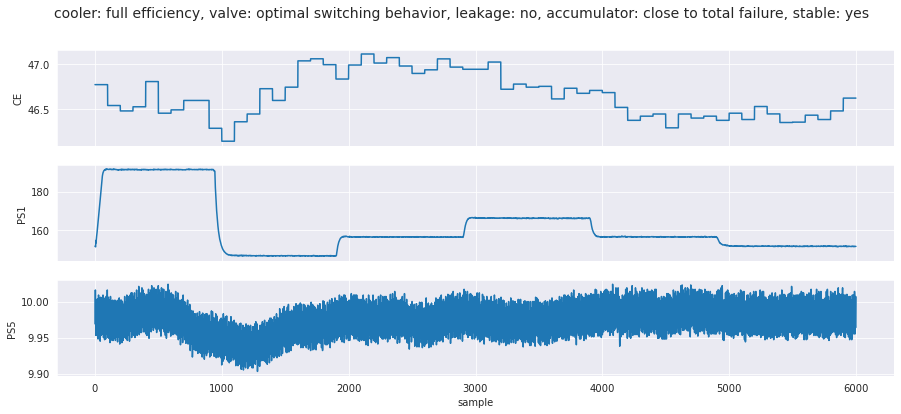

In [26]:
plot_profile(feature_df, profile_id=2205, target_df=target_df, features=["CE", "PS1", "PS5"])

In [18]:
def count_targets(df: pd.DataFrame):
    for target in TARGET_NAMES:
        encoder = generate_encoder(TARGET_VALUES_MAP, target)
        data = df[target].map(encoder)
        print(f"Distribution of '{target}' target:\n{data.value_counts()}\n")

In [19]:
count_targets(target_df)

Distribution of 'cooler' target:
full efficiency           741
close to total failure    732
reduced effifiency        732
Name: cooler, dtype: int64

Distribution of 'valve' target:
optimal switching behavior    1125
severe lag                     360
close to total failure         360
small lag                      360
Name: valve, dtype: int64

Distribution of 'leakage' target:
no        1221
severe     492
weak       492
Name: leakage, dtype: int64

Distribution of 'accumulator' target:
close to total failure       808
optimal pressure             599
severely reduced pressure    399
slightly reduced pressure    399
Name: accumulator, dtype: int64

Distribution of 'stable' target:
yes    1449
not     756
Name: stable, dtype: int64



In [20]:

# Save as Excel
target_df


,profile_id,cooler,valve,leakage,accumulator,stable
0,1,3,100,0,130,1
1,2,3,100,0,130,1
2,3,3,100,0,130,1
3,4,3,100,0,130,1
4,5,3,100,0,130,1
...,...,...,...,...,...,...
2200,2201,100,100,0,90,0
2201,2202,100,100,0,90,0
2202,2203,100,100,0,90,0
2203,2204,100,100,0,90,0


In [21]:
feature_df.to_csv('/kaggle/working/target_df.csv', index=False)


In [22]:
dataaa=pd.read_csv('/kaggle/input/condition-monitoring-of-hydraulic-systems/PS3.txt')

In [23]:
dataaa.head(200)

2.305\t2.305\t2.336\t2.578\t2.977\t3.234\t2.414\t0.805\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1.758\t6.562\t9.883\t10.039\t9.672\t9.273\t8.867\t8.656\t8.305\t7.891\t7.734\t7.57\t7.203\t7\t6.891\t6.695\t6.687\t6.586\t6.336\t6.234\t6.164\t6.086\t5.922\t5.734\t5.656\t5.547\t5.445\t5.242\t5.164\t5.164\t5.086\t4.969\t4.844\t4.898\t4.898\t4.68\t4.461\t4.453\t4.43\t4.352\t4.32\t4.219\t4.125\t4.07\t4.016\t4\t3.859\t3.766\t3.836\t3.773\t3.719\t3.672\t3.609\t3.602\t3.547\t3.492\t3.531\t3.578\t3.477\t3.422\t3.359\t3.312\t3.305\t3.234\t3.25\t3.273\t3.18\t3.109\t3.125\t3.141\t3.094\t3.086\t3.031\t2.961\t2.953\t2.906\t2.891\t2.922\t2.93\t2.953\t2.867\t2.773\t2.789\t2.82\t2.797\t2.742\t2.719\t2.703\t2.711\t2.719\t2.703\t2.664\t2.68\t2.703\t2.703\t2.656\t2.57\t2.602\t2.625\t2.633\t2.703\t2.703\t2.711\t2.711\t2.703\t2.703\t2.664\t2.68\t2.687\t2.656\t2.656\t2.664\t2.687\t2.625\t2.539\t2.492\t2.484\t2.484\t2.5\t2.445\t2.437\t2.492\t2.461\t2.516\t2.547\t2.437\t2.383\t2.43\t2.43\t2.383\t2.375\t2.406\t2.391\t2.414\t2.43\t2.43\t2.445\t2.359\t2.328\t2.32\t2.281\t2.375\t2.445\t2.406\t2.414\t2.484\t2.547\t2.594\t2.547\t2.523\t2.539\t2.469\t2.43\t2.461\t2.492\t2.445\t2.406\t2.43\t2.43\t2.406\t2.43\t2.414\t2.352\t2.305\t2.305\t2.273\t2.273\t2.328\t2.328\t2